# <div style="text-align: center">LTI Reconstruction Demo </div>
<div style="text-align: center">AWESEM Signal Processing </div>
<br>
<div style="text-align: center">Erick Blankenberg, 8/5/2019 </div>

---
## <div style="text-align: center">Introduction </div>
In this module we apply the system model that we observed from the phase-magnitude demo to an arbitrary driving waveform.
<br>
<br>
Below we import both model parameters from the aftermentioned demo and the arbitrary waveform data (a 256 sample array) that would be loaded in a microcontroller. 
<br>
<br>
The microcontroller plays back linearily interpolated values of this stored data at 44,117.64706 Hz. This waveform is constructed for the chosen target frequency as shown below.

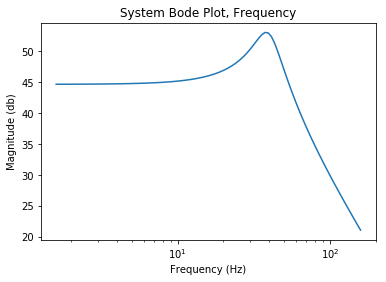

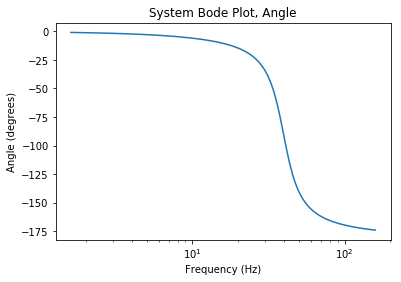

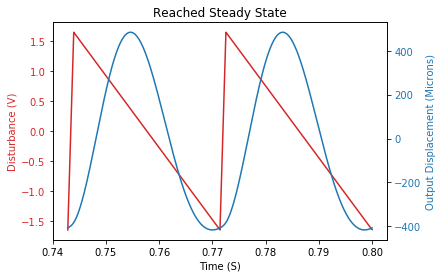

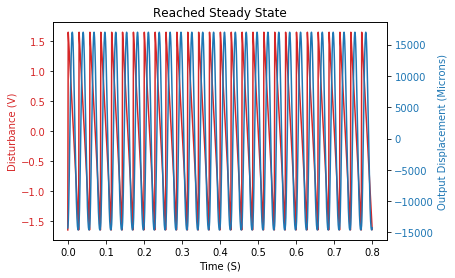

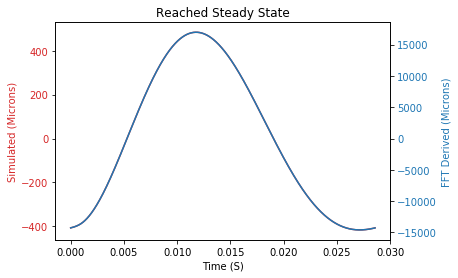

441570543.5154077
16477.14810069189


In [149]:
import numpy
import pandas
from   scipy import signal
from   scipy import fftpack
import os
import matplotlib.pyplot as pyplot
from math import ceil
import timeit

%matplotlib inline

systemAudioRate   = 44117.64706 # (Hz) How fast the MCU will create samples 
waveformFrequency = 1 # (Hz) how fast we want to play the periodic waveform

# Imports system
systemParameterFilePath = os.path.join(os.getcwd(), 'SystemParams/TransFunc_OIS.txt')
with open(systemParameterFilePath,'r') as inf:
    systemParameters = eval(inf.read())
SystemModel      = signal.ZerosPolesGain(systemParameters['Zeros'], systemParameters['Poles'], systemParameters['Gain'])

# Imports waveform
wavetableFilePath       = os.path.join(os.getcwd(), 'WaveTables/WaveTable_Custom.csv')
wavetableRaw = numpy.genfromtxt(wavetableFilePath, delimiter = ',')
# > You can uncomment this to make a skewed triangular waveform
totLength = 256
riseLength = 10
wavetableRaw = numpy.round(numpy.concatenate((numpy.linspace(-32767, 32767, riseLength, endpoint = False), numpy.linspace(32767, -32767, totLength - riseLength, endpoint = False)))).astype(numpy.int16)
#numpy.savetxt("Waveform_CustomTriangle.csv", vals)

# Imports the wave table data
waveformPeriodLength = 1.0 / waveformFrequency
wavetablePadded = (numpy.append(wavetableRaw, wavetableRaw[0]) / 32767.0) * (3.3 / 2.0) # Convertes 16 bit signed integer to vpp, also pads with 0 at end to emulate wraparound, note that MCU does the same thing
wavetableTimes  = numpy.append(numpy.arange(start = 0, stop = waveformPeriodLength, step = waveformPeriodLength / float(wavetableRaw.shape[0])), waveformPeriodLength + waveformPeriodLength / float(wavetableRaw.shape[0]))
oneShotTimes = numpy.arange(start = 0, stop = waveformPeriodLength, step = 1.0/systemAudioRate)
oneShotVals  = numpy.interp(oneShotTimes, wavetableTimes, wavetablePadded)

# Plots bode plot of system
w, mag, phase = SystemModel.bode()
pyplot.figure()
pyplot.title('System Bode Plot, Frequency')
pyplot.xlabel('Frequency (Hz)')
pyplot.ylabel('Magnitude (db)')
pyplot.semilogx(w / (2.0 * numpy.pi), mag)    # Bode magnitude plot
pyplot.figure()
pyplot.title('System Bode Plot, Angle')
pyplot.xlabel('Frequency (Hz)')
pyplot.ylabel('Angle (degrees)')
pyplot.semilogx(w / (2.0 * numpy.pi), phase)  # Bode phase plot
pyplot.show()

# Plots wave table for one period at desired frequency
periodLength = oneShotVals.shape[0]
colorDisturbance = 'tab:red'
colorResponse = 'tab:blue'
extendedShotVals  = numpy.tile(oneShotVals, int(ceil(0.8 * 35)))
extendedShotTimes = numpy.linspace(0, 0.8, extendedShotVals.shape[0])
pyplot.plot(extendedShotTimes[-(2 * periodLength):], extendedShotVals[-(2 * periodLength):], color = colorDisturbance)
pyplot.ylabel('Disturbance (V)', color = colorDisturbance)
pyplot.tick_params(axis='y', labelcolor=colorDisturbance)
pyplot.xlabel('Time (S)')
(newTime, newVals, xOut) = signal.lsim(SystemModel, extendedShotVals, extendedShotTimes, interp = "False")
# %timeit signal.lsim(SystemModel, extendedShotVals, extendedShotTimes, interp = "False") # About 180 ms on my machine 
secondPlot = pyplot.twinx()
secondPlot.plot(newTime[-(2 * periodLength):], newVals[-(2 * periodLength):], color = colorResponse)
secondPlot.set_ylabel('Output Displacement (Microns)', color = colorResponse)
secondPlot.tick_params(axis='y', labelcolor=colorResponse)
pyplot.title('Reached Steady State')
pyplot.show()

impulseResp = fftpack.ifft(fftpack.fft(SystemModel.impulse(T = extendedShotTimes)[1]) * fftpack.fft(extendedShotVals)) / systemAudioRate
# %timeit fftpack.ifft(fftpack.fft(SystemModel.impulse(T = extendedShotTimes)[1]) * fftpack.fft(extendedShotVals)) / systemAudioRate # About 53 ms on my machine (dft circular conv. is faster)
pyplot.plot(extendedShotTimes[:], extendedShotVals[:], color = colorDisturbance)
pyplot.ylabel('Disturbance (V)', color = colorDisturbance)
pyplot.tick_params(axis='y', labelcolor=colorDisturbance)
pyplot.xlabel('Time (S)')
secondPlot = pyplot.twinx()
secondPlot.plot(extendedShotTimes[:], impulseResp[:], color = colorResponse)
secondPlot.set_ylabel('Output Displacement (Microns)', color = colorResponse)
secondPlot.tick_params(axis='y', labelcolor=colorResponse)
pyplot.title('Reached Steady State')
pyplot.show()

pyplot.plot(extendedShotTimes[:periodLength], newVals[-periodLength:], color = colorDisturbance)
pyplot.ylabel('Simulated (Microns)', color = colorDisturbance)
pyplot.tick_params(axis='y', labelcolor=colorDisturbance)
pyplot.xlabel('Time (S)')
secondPlot = pyplot.twinx()
secondPlot.plot(extendedShotTimes[:periodLength], impulseResp[:periodLength], color = colorResponse)
secondPlot.set_ylabel('FFT Derived (Microns)', color = colorResponse)
secondPlot.tick_params(axis='y', labelcolor=colorResponse)
pyplot.title('Reached Steady State')
pyplot.show()

print(numpy.sum(numpy.absolute(impulseResp[:periodLength] - newVals[-periodLength:])))
print(numpy.max(numpy.absolute(impulseResp[:periodLength] - newVals[-periodLength:])))

We are interested in applying the frequency response of our system to the driving waveform. Scipy.signals has a function to apply an LTI transfer function to time series data but we are interested in the steady state periodic behavior. 
<br>
<br>
We therefore find the fourier transform of our drive waveform and multiply by an impulse train (sample) as multiplcation in the frequency domain corresponds to 

2.7.16


There are a few ways to find the steady state response of the system to the periodic input. 
<br>
<br>
The brute force approach is to use the "l-sim" method given by scipy signal, which simulates the system in the time domain with the given input signal directly. In this case we set "interp = False" as in reality our simulated discrete waveform is reconstructed using a zero-order hold by the microcontroller at 44,117.64706 Hz (our simulated waveform has one sample per hold period). This method requires that we extend our input waveform so that the response to the final period is representative of steady state. We identify the steady state behavior by isolating the last period.
<br>
<br>
The other approach is to find the response of the system to this periodic input via circular convolution. As the impulse response of the system is substantially longer than the waveform period (for this system and for most frequencies of interest) we extend the waveform as above and also zero-pad the impulse response so that it is the same length as this vector (assuming that last valid sample of the impulse response is very small). We then find the DFT of both of these vectors, multiply, than take the inverse DFT. Any of the periods in the result should be a valid representation of the steady state behavior assuming that we captured the impulse response sufficiently.
<br>
<br>
See both reconstructions and timing data below. 